#### The goal of this script is to investigate the correlation between miRNA and mRNA in our dataset to elucidate functional relationships between the two. Figures will output into the "Figures" folder.

In [1]:
# Necessary Imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from scipy import stats

In [2]:
# Opening the miRNA and mRNA matricies

miRNA_data =np.genfromtxt('../Organized_Data/miRNA_Cancer_Data.csv', 
                           delimiter=',')
mRNA_data = np.genfromtxt('../Organized_Data/mRNA_Cancer_Data.csv', 
                          delimiter=',')

In [3]:
# Getting list of miRNA and mRNA titles

# File names to get titles from (they are the same in all files)
path = '../Data/GDC_Data/'
mRNA_file = '68872445-c6f8-4e6a-b0b3-dcaa53e70e56.FPKM.txt.gz'
miRNA_file = 'fff1c9a0-c06e-4b12-b917-9f895d38b5f0.' + \
                'mirbase21.mirnas.quantification.txt'


'''miRNA titles'''

miRNA_file = path + miRNA_file

# Load the microRNA file as an array
mirnas = np.loadtxt(miRNA_file, dtype='str')
            
# Removing the column titles
mirnas = np.delete(mirnas, 0, 0)

# Pull out the titles
miRNA_titles = mirnas[:,0]

'''mRNA titles'''

mRNA_file = path + mRNA_file

# These files are zipped, need to open using pandas
mRNAs_dF = pd.read_csv(mRNA_file, sep='\t', header=None)
mRNAs_dF.columns = ["mRNA_Name", "Normalized_Count"]

# Pull out titles
mRNA_titles = mRNAs_dF["mRNA_Name"].to_numpy()

In [4]:
'''
There are too much data to check all pairwise correlations of miRNA
and mRNA, so first we will just look at miRNA with average counts 
above 1000 for the patients. Making a smaller miRNA matrix with 
just these miRNA data.
'''

# List of miRNA names whose average counts are above 1000
miRNA_1000_titles = []
miRNA_1000_titles.append(miRNA_titles[0])

# Matrix storing the miRNA data
miRNA_1000_data = miRNA_data[:,0]

# For each miRNA in the original data
for col in range(1, len(miRNA_data)):
    
    # If the average count is above 1000
    if np.average(miRNA_data[:,col]) > 1000:
        
        # Append the miRNA name to the list
        miRNA_1000_titles.append(miRNA_titles[col])
        
        # Append the data to a matrix
        miRNA_1000_data = np.vstack([miRNA_1000_data, 
                                     miRNA_data[:,col]])

miRNA_1000_data = np.transpose(miRNA_1000_data)

In [5]:
# Saving matrix to a csv file

np.savetxt('../Organized_Data/miRNA_1000_Data.csv', 
           miRNA_1000_data, delimiter=",")

In [6]:
'''
Function to make a correlation matrix between miRNA and mRNA. Two
matricies will be generated, one will hold Pearsons correlation 
coefficients and the other will hold the corresponding p-value.

Inputs:
mRNA_titles = numpy array with the names of all mRNAs to investigate
miRNA_titles = numpy array with the names of all miRNAs to 
investigate
miRNA_data = numpy array containing all miRNA counts, with the 
patients as rows and miRNAs as columns
mRNA_data = numpy array containing all mRNA counts, with the
patients as rows and mRNAs as columns

Outputs:
corr_mat = numpy array correlation matrix, with mRNAs as rows and 
miRNAs as columns
pval_mat = matrix of the same size as corr_mat containing p-values
associated with each correlation
'''

def corr_matrix(mRNA_titles, miRNA_titles, miRNA_data, mRNA_data):
    
    # Initializing matricies
    corr_mat = np.empty((len(mRNA_titles), len(miRNA_titles)))
    pval_mat = np.empty((len(mRNA_titles), len(miRNA_titles)))
    
    # For every mRNA
    for row_index in range(len(mRNA_titles)):
        
        # For every miRNA:
        for column_index in range(len(miRNA_titles)):
            
            # Calculate pearson correlation and p value
            (corr, pval) = stats.pearsonr(miRNA_data[:, 
                            column_index], mRNA_data[:, row_index])
            
            # Add the values to their matricies
            corr_mat[row_index, column_index] = corr
            pval_mat[row_index, column_index] = pval
            
    return (corr_mat, pval_mat)

In [7]:
'''
Function to find miRNA and mRNA pairs from a correlation matrix
that have correlations above or below a specified cutoff. Makes a
dictionary of these pairs, the correlation coefficient, and p
value. If there are strong correlations, we hypothesize that
there is a functional relationship between these miRNA and mRNA.

Input:
pos_corr_cutoff = float of the upper limit value for correlation
coefficient to find (between -1.0 and 1.0)
neg_corr_cutoff = float of the lower limit value for correlation
coefficient to find (between -1.0 and 1.0)
corr_mat = numpy array correlation matrix, with mRNAs as rows and 
miRNAs as columns
mRNA_titles = numpy array with the names of all mRNAs to investigate
miRNA_titles = numpy array with the names of all miRNAs to 
investigate
pval_mat = matrix of the same size as corr_mat containing p-values
associated with each correlation

Output:
miRNA_mRNA_pairs = Dictionary with all correlations meeting the
specified criteria. Keys are miRNA, values are lists with each
mRNA they are correlated with, their correlation coefficient, and
p values.
miRNA_sig = list of miRNA that have correlations meeting the
specified criteria
mRNA_sig = list of mRNA that have correlations meeting the
specified criteria
'''

def get_cutoff_corr(pos_corr_cutoff, neg_corr_cutoff, corr_mat, 
                    mRNA_titles, miRNA_titles, pval_mat):
    
    # Dictionary of miRNA and mRNA pairs
    miRNA_mRNA_pairs = {}
    
    # Significant miRNA and mRNA for plotting later
    miRNA_sig = []
    mRNA_sig = []
    
    # For every mRNA
    for row_index in range(len(mRNA_titles)):

        # For every miRNA:
        for column_index in range(len(miRNA_titles)):
            
            # If the pearson correlation coefficient is great or 
            # less than the defined cutoffs
            if corr_mat[row_index, column_index] <= \
            neg_corr_cutoff or\
            corr_mat[row_index, column_index] >= \
            pos_corr_cutoff:
                
                # Retrieve the miRNA and mRNA names
                mRNA_name = mRNA_titles[row_index]
                miRNA_name = miRNA_titles[column_index]

                # Add this pair, the correlation coefficient, and
                # the p-value to the dictionary
                
                dict_value = [mRNA_name, 
                    corr_mat[row_index, column_index],
                    pval_mat[row_index, column_index]]
            
                if miRNA_name not in miRNA_mRNA_pairs:
                    miRNA_mRNA_pairs[miRNA_name] = dict_value
                else:
                    orig_value = miRNA_mRNA_pairs[miRNA_name]
                    new_value = orig_value + dict_value
                    miRNA_mRNA_pairs[miRNA_name] = new_value
                    
                # Also adding the miRNA and mRNA names to a list
                # for plotting later
                if miRNA_name not in miRNA_sig:
                    miRNA_sig.append(miRNA_name)
                if mRNA_name not in mRNA_sig:
                    mRNA_sig.append(mRNA_name)
                    
    return (miRNA_mRNA_pairs, miRNA_sig, mRNA_sig)

In [8]:
'''
Function to select specified rows and columns of a correlation
matrix for plotting.

Input:
miRNA_sig = list of miRNAs to select from matrix
mRNA_sig = list of mRNAs to select from matrix
mRNA_titles = numpy array with the names of all mRNAs to investigate
miRNA_titles = numpy array with the names of all miRNAs to 
investigate
corr_mat = numpy array with correlation matrix, with mRNAs as rows 
and miRNAs as columns

Output:
corr_mRNA_miRNA = numpy array with subset of correlation matrix
specified
'''

def get_subset_corr_mat(miRNA_sig, mRNA_sig, mRNA_titles, 
                        miRNA_titles, corr_mat):

    # Lists of desired indecies from correlation matrix
    miRNA_filter_indices = []
    mRNA_filter_indices = []

    # Getting indecies of significant miRNA, appending to list
    for miRNA in miRNA_sig:
        index = miRNA_titles.index(miRNA)
        miRNA_filter_indices.append(index)

    # Getting indecies of significant miRNA, appending to list
    for mRNA in mRNA_sig:
        index = np.where(mRNA_titles == mRNA)[0][0]
        mRNA_filter_indices.append(index)

    # Selecting subset of correlation matrix to plot
    axis = 0
    corr_mRNA = np.take(corr_mat, mRNA_filter_indices, axis)
    axis = 1
    corr_mRNA_miRNA = np.take(corr_mRNA, miRNA_filter_indices, axis)
    
    return corr_mRNA_miRNA

In [9]:
'''
Making correlation matrix with all miRNAs with average counts above
1000 in the cancerous data. One matrix will hold Pearsons 
correlation coefficient and the ohter will hold the corresponding 
p-value.
'''

(corr_mat_1000, pval_mat_1000) = corr_matrix(mRNA_titles, 
                    miRNA_1000_titles, miRNA_1000_data, mRNA_data)

/Users/allisonlemmer/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
'''
Finding the miRNA and mRNA pairs in this matrix that meet the
specified correlation criteria.
'''

pos_corr_cutoff = 0.7
neg_corr_cutoff = -0.4

(miRNA_mRNA_pairs, miRNA_sig, mRNA_sig) = get_cutoff_corr\
        (pos_corr_cutoff, neg_corr_cutoff, corr_mat_1000, 
         mRNA_titles, miRNA_1000_titles, pval_mat_1000)

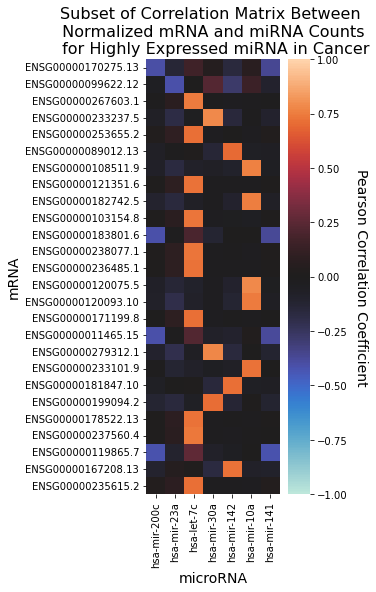

In [11]:
'''
Making a heatmap of the correlation values just for the miRNA and 
mRNA of interest for visualization.
'''

# Getting subset of correlation matrix to plot
corr_mRNA_miRNA = get_subset_corr_mat(miRNA_sig, mRNA_sig, 
                mRNA_titles, miRNA_1000_titles, corr_mat_1000)

# Plotting
plt.rcParams["figure.figsize"] = (3, 8)
fig = plt.figure()
ax = sns.heatmap(corr_mRNA_miRNA, xticklabels = miRNA_sig, 
                 yticklabels = mRNA_sig, vmin = -1.0, vmax = 1.0, 
                 center = 0.0)
ax.collections[0].colorbar.set_label \
    ("Pearson Correlation Coefficient", fontsize = 14, 
     rotation = 270, labelpad=20)
ax.set_xlabel('microRNA', fontsize = 14)
ax.set_ylabel('mRNA', fontsize = 14)
ax.set_title('Subset of Correlation Matrix Between \n Normalized' + 
             ' mRNA and miRNA Counts \n for ' +
            'Highly Expressed miRNA in Cancer', fontsize = 16)
fig.savefig('../Figures/Correlation_Matrix_1000.png', 
            bbox_inches='tight')

In [12]:
'''
Next, we will specifically look at the 9 miRNAs that are down-
regulated according to our previous analysis. In this code block,
the patient data for just these miRNA are being collected into one
matrix.
'''

# miRNA to investigate
miRNA_spec = ['hsa-mir-486-1', 'hsa-mir-486-2', 'hsa-mir-139', 
              'hsa-mir-451a', 'hsa-mir-144', 'hsa-mir-4732', 
              'hsa-mir-204', 'hsa-mir-6715a', 'hsa-mir-6507']

# Lists of desired indecies from miRNA matrix
miRNA_spec_filter_indices = []

# Getting indecies of these miRNA, appending to list
for miRNA in miRNA_spec:
    index = np.where(miRNA_titles == miRNA)[0][0]
    miRNA_spec_filter_indices.append(index)

# Matrix storing the miRNA data
miRNA_spec_data = miRNA_data[:,miRNA_spec_filter_indices[0]]

# For each miRNA we want to speculate
for index in range(1, len(miRNA_spec)):
    
    # Add those miRNA data to our matrix
    miRNA_spec_data = np.vstack([miRNA_spec_data, 
                miRNA_data[:,miRNA_spec_filter_indices[index]]])

miRNA_spec_data = np.transpose(miRNA_spec_data)

In [13]:
'''
Making correlation matrix with these 9 miRNAs. One matrix will hold 
Pearsons correlation coefficient and the ohter will hold the 
corresponding p-value.
'''

(corr_mat_9, pval_mat_9) = corr_matrix(mRNA_titles, miRNA_spec, 
                                       miRNA_spec_data, mRNA_data)

In [14]:
'''
Finding the miRNA and mRNA pairs in this matrix that meet the
specified correlation criteria.
'''

pos_corr_cutoff = 0.7
neg_corr_cutoff = -0.4

(miRNA_mRNA_pairs_spec, miRNA_sig_spec, mRNA_sig_spec) = \
        get_cutoff_corr(pos_corr_cutoff, neg_corr_cutoff, 
                corr_mat_9, mRNA_titles, miRNA_spec, pval_mat_9)

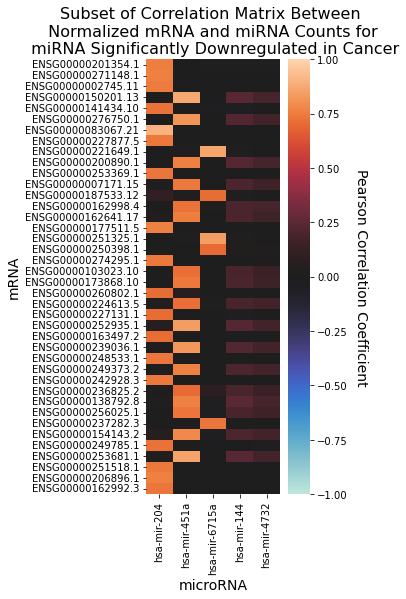

In [17]:
'''
Making a heatmap of the correlation values just for the miRNA and 
mRNA of interest for visualization.
'''

# Getting subset of correlation matrix to plot
corr_mRNA_miRNA = get_subset_corr_mat(miRNA_sig_spec, mRNA_sig_spec, 
                            mRNA_titles, miRNA_spec, corr_mat_9)

# Plotting
fig = plt.figure()
plt.rcParams["figure.figsize"] = (3, 8)
ax = sns.heatmap(corr_mRNA_miRNA[0:40,:], 
                 xticklabels = miRNA_mRNA_pairs_spec, 
                 yticklabels = mRNA_sig_spec[0:40], vmin = -1.0, 
                 vmax = 1.0, center = 0.0)

ax.collections[0].colorbar.set_label \
    ("Pearson Correlation Coefficient", fontsize = 14, 
     rotation = 270, labelpad=20)
ax.set_xlabel('microRNA', fontsize = 14)
ax.set_ylabel('mRNA', fontsize = 14)
ax.set_title('Subset of Correlation Matrix Between \n Normalized' + 
             ' mRNA and miRNA Counts for \n ' +
            'miRNA Significantly Downregulated in Cancer', 
             fontsize = 16)
fig.savefig('../Figures/Correlation_Matrix_9.png', 
            bbox_inches='tight')

In [18]:
# Printing out mRNA involved for gene ontology analysis

for miRNA in miRNA_mRNA_pairs_spec:
    print(miRNA + ':')
    
    values = miRNA_mRNA_pairs_spec[miRNA]
    print(values[::3])

hsa-mir-204:
['ENSG00000201354.1', 'ENSG00000271148.1', 'ENSG00000002745.11', 'ENSG00000141434.10', 'ENSG00000083067.21', 'ENSG00000227877.5', 'ENSG00000253369.1', 'ENSG00000177511.5', 'ENSG00000274295.1', 'ENSG00000260802.1', 'ENSG00000227131.1', 'ENSG00000163497.2', 'ENSG00000248533.1', 'ENSG00000242928.3', 'ENSG00000249785.1', 'ENSG00000251518.1', 'ENSG00000206896.1', 'ENSG00000162992.3', 'ENSG00000152954.10', 'ENSG00000257308.1', 'ENSG00000230852.1', 'ENSG00000075429.7', 'ENSG00000147481.12', 'ENSG00000249487.5']
hsa-mir-451a:
['ENSG00000150201.13', 'ENSG00000276750.1', 'ENSG00000200890.1', 'ENSG00000007171.15', 'ENSG00000162998.4', 'ENSG00000162641.17', 'ENSG00000103023.10', 'ENSG00000173868.10', 'ENSG00000224613.5', 'ENSG00000252935.1', 'ENSG00000239036.1', 'ENSG00000249373.2', 'ENSG00000236825.2', 'ENSG00000138792.8', 'ENSG00000256025.1', 'ENSG00000154143.2', 'ENSG00000253681.1', 'ENSG00000281579.1', 'ENSG00000248279.4', 'ENSG00000235334.1', 'ENSG00000199200.2', 'ENSG00000237860